<a href="https://colab.research.google.com/github/itsJeromeJ/animal_detector/blob/main/animal_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install the necessary packages
! pip install torch torchvision Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:

# Define your dataset and model code here (copy-paste your existing code)
import torch
import torch.optim as optim
import torchvision
from torchvision import transforms
from PIL import Image
import os
import json
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.detection import FasterRCNN

# Your existing code (class definitions, etc.) here...

# Set up the data paths
img_dir = "/content/182.png"
annotation_file = "/content/lion_annotations.json"


In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define your classification model (MyModel) for Cheetah vs Not Cheetah
class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        # Example layers (replace with your actual model layers)
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(64 * 640 * 640, 2)  # Example, adjust the dimensions

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)  # Flatten the output for fully connected layer
        x = self.fc1(x)
        return x

# Load the fine-tuned Faster R-CNN model for cheetah detection
def load_faster_rcnn_model():
    model = fasterrcnn_resnet50_fpn(weights=None)
    num_classes = 2  # For 'background' and 'cheetah'
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Load state_dict with strict=False to ignore missing/unexpected keys
    state_dict = torch.load('/content/lion_detection_model.pth')
    model.load_state_dict(state_dict, strict=False)
    model.eval()
    return model

# Define class names for Faster R-CNN
class_names = ['background', 'lion']

# Function to preprocess the image for classification (Cheetah vs Not Cheetah)
def preprocess_for_classification(image_path):
    transform = transforms.Compose([
        transforms.Resize((640, 640)),  # Resize to match model's expected input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize if required
    ])
    image = Image.open(image_path)
    return transform(image).unsqueeze(0)  # Add batch dimension

# Function to make predictions using the classification model
def classify_cheetah(image_path, model, threshold=0.5):
    input_image = preprocess_for_classification(image_path)

    with torch.no_grad():
        outputs = model(input_image)
        probabilities = F.softmax(outputs, dim=1)

    cheetah_prob = probabilities[0][1].item()  # Probability for 'Cheetah' class (index 1)
    not_cheetah_prob = probabilities[0][0].item()  # Probability for 'Not Cheetah' class (index 0)

    # Debugging: Print probabilities to check the output
    print(f"Class Probabilities (Not lion,lion): {probabilities[0].tolist()}")  # Prints probabilities for both classes
    print(f"Confidence in lion: {cheetah_prob:.2f}, Confidence in Not lion: {not_cheetah_prob:.2f}")

    if cheetah_prob >= threshold:  # If the probability for 'Cheetah' is above threshold
        print(f"Cheetah (Confidence: {cheetah_prob:.2f})")
        return True
    else:  # If the probability is below threshold
        print(f"Not Cheetah (Confidence: {cheetah_prob:.2f})")
        return False

# Function to preprocess the image for Faster R-CNN
def preprocess_for_detection(image_path):
    transform = transforms.Compose([transforms.ToTensor()])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

# Function to make predictions with Faster R-CNN
def predict_with_nms(image_path, model, threshold=0.5, iou_threshold=0.4):
    image_tensor = preprocess_for_detection(image_path)

    with torch.no_grad():
        predictions = model(image_tensor)

    # Extract predictions from the first batch (single image)
    predictions = predictions[0]
    boxes = predictions['boxes']
    scores = predictions['scores']
    labels = predictions['labels']

    # Apply NMS to remove redundant overlapping boxes
    keep = torch.ops.torchvision.nms(boxes, scores, iou_threshold)
    boxes = boxes[keep]
    scores = scores[keep]
    labels = labels[keep]

    # Apply confidence threshold to keep only high-confidence predictions
    keep = scores >= threshold
    boxes = boxes[keep]
    scores = scores[keep]
    labels = labels[keep]

    # If multiple predictions exist, keep only the one with the highest confidence
    if scores.size(0) > 0:
        max_index = torch.argmax(scores)
        boxes = boxes[max_index:max_index + 1]  # Keep only the best box
        scores = scores[max_index:max_index + 1]
        labels = labels[max_index:max_index + 1]

    # Return filtered predictions
    return {'boxes': boxes, 'scores': scores, 'labels': labels}

# Function to visualize the detection results with enlarged bounding boxes
def visualize_detections(image_path, predictions, scale_width=1.3, scale_height=1.5):
    image = Image.open(image_path).convert("RGB")
    img_width, img_height = image.size
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    for box, score, label in zip(predictions['boxes'], predictions['scores'], predictions['labels']):
        x_min, y_min, x_max, y_max = box.cpu().numpy()  # Convert to numpy for visualization

        # Calculate box center and dimensions
        box_width = x_max - x_min
        box_height = y_max - y_min
        center_x = x_min + box_width / 2
        center_y = y_min + box_height / 2

        # Scale the box dimensions
        box_width *= scale_width
        box_height *= scale_height
        x_min = max(center_x - box_width / 2, 0)  # Ensure box stays within image bounds
        y_min = max(center_y - box_height / 2, 0)
        x_max = min(center_x + box_width / 2, img_width)
        y_max = min(center_y + box_height / 3, img_height)

        # Draw rectangle for the bounding box
        rect = patches.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=2,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)

        # Add class name and score as text
        class_name = class_names[int(label)]
        ax.text(
            x_min,
            y_min - 10,
            f"{class_name}: {score:.2f}",
            fontsize=10,
            color='yellow',
            bbox=dict(facecolor='blue', alpha=0.5)
        )

    plt.axis('off')  # Hide axes for a cleaner look
    plt.show()

# Path to the test image
test_image_path = "/content/182.png"

# Load models
classification_model = MyModel()  # Replace with your actual classification model
faster_rcnn_model = load_faster_rcnn_model()

# Classify the image
if classify_cheetah(test_image_path, classification_model, threshold=0.5):  # Threshold adjusted to 0.5
    # If the image is classified as "Cheetah", perform detection
    predictions = predict_with_nms(test_image_path, faster_rcnn_model, threshold=0.9, iou_threshold=0.4)
    visualize_detections(test_image_path, predictions, scale_width=1.6, scale_height=1.9)
else:
    print("Not a Cheetah image.")


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 81.7MB/s]


RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

In [ ]:
!pip install tensorflow-gpu

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!nvidia-smi

Thu Apr  3 06:58:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [ ]:
# ! pip install tensorflow numpy matplotlib
# !pip install tensorflow
!pip install --upgrade pip setuptools wheel


In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
image_size=[224,224]
train_path='/content/drive/MyDrive/lion_tiger/train/lion'
test_path='/content/drive/MyDrive/lion_tiger/test/lion'

In [ ]:
inception=InceptionV3(input_shape=image_size+[3],weights='imagenet',include_top=False)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
for layer in inception.layers:
  layer.trainable=False

In [ ]:
folder=glob('/content/drive/MyDrive/lion_tiger/train/lion')

In [ ]:
x= Flatten()(inception.output)

In [ ]:
prediction=Dense(len(folder),activation='softmax')(x)

In [ ]:
model=Model(inputs=inception.input,outputs=prediction)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,853,985 (83.37 MB)

 Trainable params: 51,201 (200.00 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
from tensorflow.keras.layers import Dense

output_layer = Dense(2, activation='softmax')(x)  # ✅ Two neurons for one-hot labels
model = Model(inputs=inception.input, outputs=output_layer)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # ✅ Categorical loss


In [ ]:
# model.compile(
#     loss='categorical_crossentropy',
#     optimizer='adam',
#     metrics=['accuracy']
# )

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_data=ImageDataGenerator(rescale=1./255,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True)
test_data=ImageDataGenerator(rescale=1./255)

In [ ]:
training_set=train_data.flow_from_directory('/content/drive/MyDrive/lion_tiger/train',
                                            target_size=(224,224),
                                            batch_size=16,
                                            class_mode='categorical')

Found 360 images belonging to 2 classes.


In [ ]:
testing_set=test_data.flow_from_directory('/content/drive/MyDrive/lion_tiger/test',
                                            target_size=(224,224),
                                            batch_size=32,
                                            class_mode='categorical')

Found 40 images belonging to 2 classes.


In [ ]:
r = model.fit(
    training_set,
    validation_data=testing_set,
    epochs=10,
    steps_per_epoch=len(training_set),
    validation_steps=len(testing_set)
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 163s 6s/step - accuracy: 0.7293 - loss: 2.6958 - val_accuracy: 0.8500 - val_loss: 1.4425
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 323ms/step - accuracy: 0.9796 - loss: 0.1787 - val_accuracy: 0.9750 - val_loss: 0.1306
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 264ms/step - accuracy: 0.9763 - loss: 0.0806 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 321ms/step - accuracy: 0.9759 - loss: 0.2515 - val_accuracy: 0.8250 - val_loss: 3.1188
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 263ms/step - accuracy: 0.9496 - loss: 0.2673 - val_accuracy: 0.7000 - val_loss: 8.3982
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step - accuracy: 0.9795 - loss: 0.2086 - val_accuracy: 0.8500 - val_loss: 2.3628
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 267ms/step - accuracy: 0.9928 - loss: 0.0662 - val_accuracy: 0.8250 - val_loss: 3.5902
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 315ms/step - accuracy: 0.9872 - loss: 0.2849 - val_accuracy: 0.8

In [ ]:
for batch in training_set:
    print("X shape:", batch[0].shape)  # Input images
    print("Y shape:", batch[1].shape)  # Target labels
    break  # Only print for one batch


X shape: (16, 224, 224, 3)
Y shape: (16, 2)


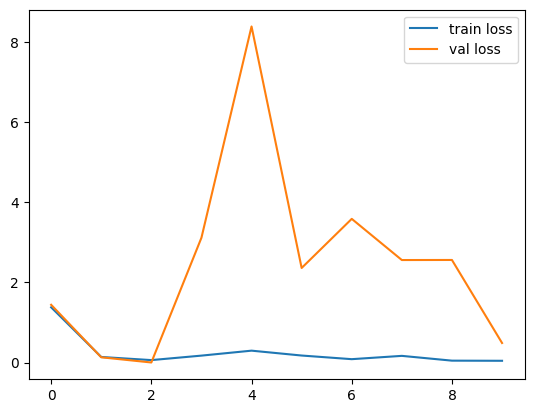

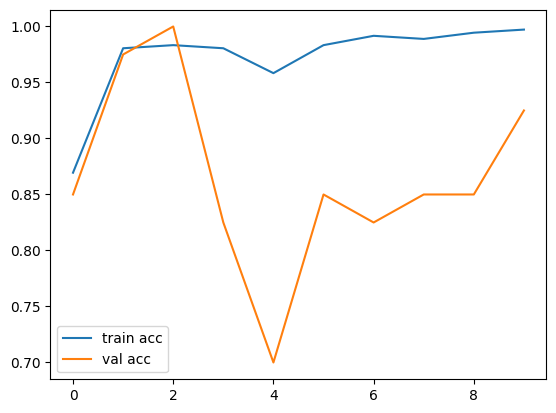

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
from tensorflow.keras.models import load_model

model.save('model_inception.h5')

In [ ]:
model = load_model('model_inception.h5')
from tensorflow.keras.preprocessing import image
import numpy as np

# Load an image for testing
img_path = '/content/lion.jpg'  # Replace with your image path
img = image.load_img(img_path, target_size=(224, 224))  # Resize to match InceptionV3 input size

# Convert the image to an array
img_array = image.img_to_array(img)

# Expand dimensions to match batch size format
img_array = np.expand_dims(img_array, axis=0)

# Normalize image (same as training)
from tensorflow.keras.applications.inception_v3 import preprocess_input
img_array = preprocess_input(img_array)  # Preprocess like InceptionV3

# Predict the class
predictions = model.predict(img_array)
print("Raw Predictions:", predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Raw Predictions: [[1.000000e+00 5.969859e-24]]


In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('model_inception.h5')

# Recompile with the same loss and optimizer (modify as per your training config)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
class_names = ['lion', 'tiger']  # Modify according to your dataset
predicted_class = np.argmax(predictions, axis=1)[0]  # Get class index
print("Predicted Class:", class_names[predicted_class])


Predicted Class: lion


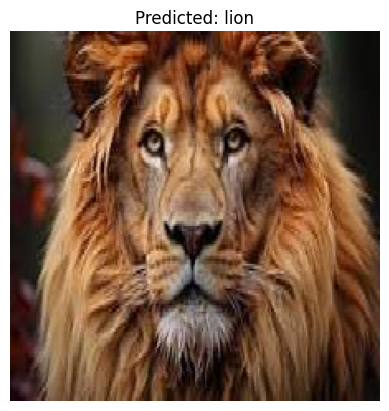

In [ ]:
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted: {class_names[predicted_class]}')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Raw Predictions: [[2.0523522e-30 1.0000000e+00]]
Predicted Class: tiger


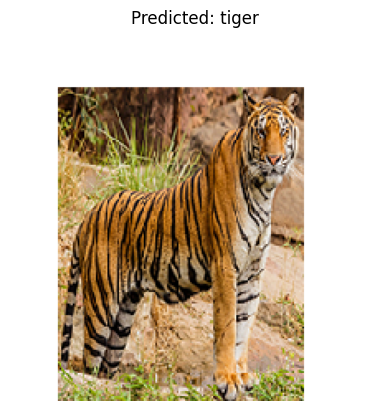

In [ ]:

# Load an image for testing
img_path = '/content/drive/MyDrive/lion_tiger/train/tiger/0.png'  # Replace with your image path
img = image.load_img(img_path, target_size=(224, 224))  # Resize to match InceptionV3 input size

# Convert the image to an array
img_array = image.img_to_array(img)

# Expand dimensions to match batch size format
img_array = np.expand_dims(img_array, axis=0)

# Normalize image (same as training)
from tensorflow.keras.applications.inception_v3 import preprocess_input
img_array = preprocess_input(img_array)  # Preprocess like InceptionV3

# Predict the class
predictions = model.predict(img_array)
print("Raw Predictions:", predictions)

class_names = ['lion', 'tiger']  # Modify according to your dataset
predicted_class = np.argmax(predictions, axis=1)[0]  # Get class index
print("Predicted Class:", class_names[predicted_class])

plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted: {class_names[predicted_class]}')
plt.show()